# KV Cache Offloading Experiment: Context-Type Impact Analysis

**Experiment**: 5 context conditions × 50 questions × cold/warm pairs  
**Model**: `openai/gpt-oss-120b` (reasoning model) via vLLM + LMCache  
**Date**: 2026-02-08  

## Research Question

> How do different Graph RAG context serialization formats (LPG structured, RDF triples, text references, combined LPG+RDF) affect KV cache reuse efficiency and answer quality in a vLLM + LMCache serving environment?

## Experimental Protocol

For each (question, condition) pair:
1. **Cold run**: fresh API call → measure latency & scrape `/metrics`
2. **Wait 3s** for LMCache to store KV cache
3. **Warm run**: identical prompt → measure latency & scrape `/metrics`
4. **Speedup** = cold_latency / warm_latency

### 5 Conditions

| Condition | Context Source | Format |
|-----------|---------------|--------|
| `lpg` | Neo4j finderlpg | GraphFormatter structured |
| `rdf` | Neo4j finderrdf | Triple format (raw URIs) |
| `text` | Parquet references | Raw text passages |
| `lpg_rdf` | Both DBs | Combined LPG + RDF |
| `vanilla` | — | No context (baseline) |

In [1]:
import json
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from scipy import stats as sp_stats

warnings.filterwarnings("ignore", category=FutureWarning)

# ── Style ──
plt.rcParams.update({
    "figure.facecolor": "#0d1117",
    "axes.facecolor": "#161b22",
    "axes.edgecolor": "#30363d",
    "axes.labelcolor": "#c9d1d9",
    "text.color": "#c9d1d9",
    "xtick.color": "#8b949e",
    "ytick.color": "#8b949e",
    "grid.color": "#21262d",
    "legend.facecolor": "#161b22",
    "legend.edgecolor": "#30363d",
    "figure.dpi": 120,
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
})

COLORS = {
    "lpg": "#58a6ff",
    "rdf": "#f78166",
    "text": "#3fb950",
    "lpg_rdf": "#d2a8ff",
    "vanilla": "#8b949e",
}
COND_ORDER = ["vanilla", "lpg", "rdf", "text", "lpg_rdf"]
COND_LABELS = {
    "vanilla": "Vanilla\n(no context)",
    "lpg": "LPG\n(structured)",
    "rdf": "RDF\n(triples)",
    "text": "Text\n(references)",
    "lpg_rdf": "LPG+RDF\n(combined)",
}

print("Setup complete.")

Setup complete.


In [2]:
# ── Load Data ──
RESULT_DIR = Path("../results/kvcache_experiment/20260208_091053")

raw = []
with open(RESULT_DIR / "results_log.jsonl") as f:
    for line in f:
        raw.append(json.loads(line))

print(f"Total entries: {len(raw)}")
print(f"By status: {pd.Series([r.get('status') for r in raw]).value_counts().to_dict()}")

# Filter to success only
success = [r for r in raw if r.get("status") == "success"]

# Build DataFrame
rows = []
for r in success:
    ev = r.get("eval", {})
    wd = r.get("warm_delta", {})
    cd = r.get("cold_delta", {})
    rows.append({
        "question_id": r["question_id"],
        "condition": r["condition"],
        "cold_latency": r["cold_latency"],
        "warm_latency": r["warm_latency"],
        "speedup": r["speedup"],
        "prompt_tokens": r["prompt_tokens"],
        "context_length": r["context_length"],
        "cold_completion_tokens": r["cold_completion_tokens"],
        "warm_completion_tokens": r["warm_completion_tokens"],
        "cold_finish_reason": r["cold_finish_reason"],
        "warm_finish_reason": r["warm_finish_reason"],
        # Quality
        "exact_match": ev.get("exact_match", 0),
        "substring_match": ev.get("substring_match", 0),
        "token_f1": ev.get("token_f1", 0),
        "rouge_1": ev.get("rouge_1", 0),
        "rouge_2": ev.get("rouge_2", 0),
        "rouge_l": ev.get("rouge_l", 0),
        # Cache deltas (warm)
        "warm_cache_hit_delta": wd.get("delta_vllm:gpu_prefix_cache_hits_total", 0),
        "warm_cache_query_delta": wd.get("delta_vllm:gpu_prefix_cache_queries_total", 0),
        "warm_cache_hitrate_delta": wd.get("delta_vllm:gpu_prefix_cache_hit_rate", 0),
        "warm_elapsed": wd.get("elapsed_sec", 0),
        "cold_elapsed": cd.get("elapsed_sec", 0),
        # vLLM internal latency delta
        "cold_avg_latency_delta": cd.get("delta_vllm:avg_latency", 0),
        "warm_avg_latency_delta": wd.get("delta_vllm:avg_latency", 0),
    })

df = pd.DataFrame(rows)
df["condition"] = pd.Categorical(df["condition"], categories=COND_ORDER, ordered=True)
df = df.sort_values("condition").reset_index(drop=True)

print(f"\nDataFrame: {df.shape[0]} rows × {df.shape[1]} cols")
print(f"Conditions: {df['condition'].value_counts().sort_index().to_dict()}")
df.head()

Total entries: 300
By status: {'success': 249, 'skipped': 51}

DataFrame: 249 rows × 24 cols
Conditions: {'vanilla': 50, 'lpg': 49, 'rdf': 50, 'text': 50, 'lpg_rdf': 50}


,question_id,condition,cold_latency,warm_latency,speedup,prompt_tokens,context_length,cold_completion_tokens,warm_completion_tokens,cold_finish_reason,...,rouge_1,rouge_2,rouge_l,warm_cache_hit_delta,warm_cache_query_delta,warm_cache_hitrate_delta,warm_elapsed,cold_elapsed,cold_avg_latency_delta,warm_avg_latency_delta
0,8bb857e8,vanilla,8.123235,8.091530,1.003918,88,0,512,512,length,...,0.329218,0.041322,0.127572,0.0,0.0,0.0,9.044711,9.118536,-0.001931,-0.018613
1,a36f14a7,vanilla,8.108300,8.094169,1.001746,83,0,512,512,length,...,0.212625,0.026756,0.119601,0.0,0.0,0.0,9.067885,9.139895,-0.000197,-0.004693
2,da91a4f3,vanilla,8.078854,8.103446,0.996965,95,0,512,512,length,...,0.242424,0.026201,0.103896,0.0,0.0,0.0,9.108427,9.048410,-0.002861,0.000791
3,3f1c27fe,vanilla,8.113248,8.121276,0.999011,82,0,512,512,length,...,0.162791,0.029240,0.081395,0.0,0.0,0.0,9.076154,9.077214,-0.003395,0.004973
4,b5dfef0e,vanilla,8.147485,8.095695,1.006397,94,0,512,512,length,...,0.260000,0.070707,0.150000,0.0,0.0,0.0,9.136609,9.109586,0.017535,-0.016644


---
## 1. Overview Statistics

In [3]:
# ── Summary Table ──
summary = df.groupby("condition", observed=True).agg(
    n=("speedup", "count"),
    cold_lat_mean=("cold_latency", "mean"),
    cold_lat_std=("cold_latency", "std"),
    warm_lat_mean=("warm_latency", "mean"),
    warm_lat_std=("warm_latency", "std"),
    speedup_mean=("speedup", "mean"),
    speedup_std=("speedup", "std"),
    prompt_tok_mean=("prompt_tokens", "mean"),
    ctx_len_mean=("context_length", "mean"),
    f1_mean=("token_f1", "mean"),
    rouge_l_mean=("rouge_l", "mean"),
    substr_match_mean=("substring_match", "mean"),
).round(3)

# Format for display
display_df = summary.copy()
display_df["cold_latency"] = display_df.apply(lambda r: f"{r.cold_lat_mean:.2f} ± {r.cold_lat_std:.2f}", axis=1)
display_df["warm_latency"] = display_df.apply(lambda r: f"{r.warm_lat_mean:.2f} ± {r.warm_lat_std:.2f}", axis=1)
display_df["speedup"] = display_df.apply(lambda r: f"{r.speedup_mean:.2f} ± {r.speedup_std:.2f}x", axis=1)
display_df = display_df[["n", "cold_latency", "warm_latency", "speedup",
                          "prompt_tok_mean", "ctx_len_mean", "f1_mean", "rouge_l_mean", "substr_match_mean"]]
display_df.columns = ["N", "Cold Latency (s)", "Warm Latency (s)", "Speedup",
                       "Prompt Tokens", "Context Chars", "Token F1", "ROUGE-L", "Substring Match"]
display_df

,N,Cold Latency (s),Warm Latency (s),Speedup,Prompt Tokens,Context Chars,Token F1,ROUGE-L,Substring Match
condition,,,,,,,,,
vanilla,50,8.12 ± 0.03,8.09 ± 0.02,1.00 ± 0.00x,89.060,0.000,0.143,0.126,0.0
lpg,49,6.86 ± 2.06,6.89 ± 1.96,1.01 ± 0.18x,339.367,847.449,0.163,0.149,0.0
rdf,50,7.05 ± 1.80,7.05 ± 1.78,1.01 ± 0.14x,294.960,634.840,0.152,0.150,0.0
text,50,7.80 ± 1.16,7.75 ± 1.11,1.01 ± 0.07x,456.540,1921.720,0.189,0.181,0.0
lpg_rdf,50,7.54 ± 1.29,7.26 ± 1.53,1.06 ± 0.21x,541.400,1519.780,0.151,0.156,0.0


---
## 2. Latency Analysis

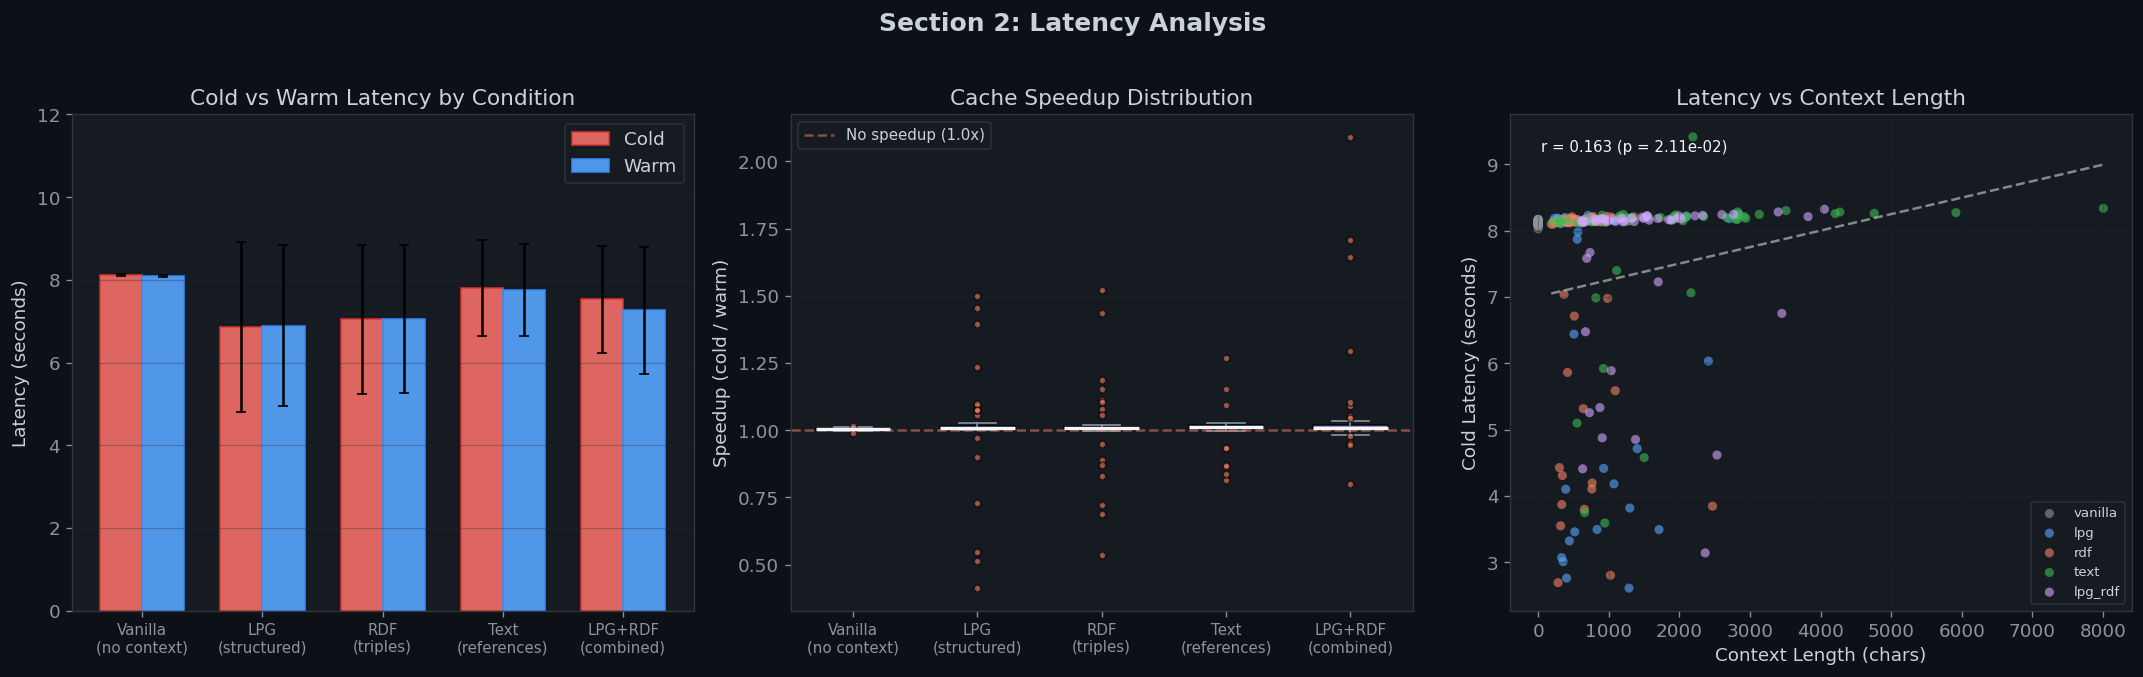

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5.5))

# ── 2a: Cold vs Warm Latency (grouped bar) ──
ax = axes[0]
x = np.arange(len(COND_ORDER))
w = 0.35
cold_means = [df[df.condition == c]["cold_latency"].mean() for c in COND_ORDER]
cold_stds = [df[df.condition == c]["cold_latency"].std() for c in COND_ORDER]
warm_means = [df[df.condition == c]["warm_latency"].mean() for c in COND_ORDER]
warm_stds = [df[df.condition == c]["warm_latency"].std() for c in COND_ORDER]

bars1 = ax.bar(x - w/2, cold_means, w, yerr=cold_stds, label="Cold",
               color="#f47067", edgecolor="#da3633", capsize=3, alpha=0.9)
bars2 = ax.bar(x + w/2, warm_means, w, yerr=warm_stds, label="Warm",
               color="#58a6ff", edgecolor="#388bfd", capsize=3, alpha=0.9)

ax.set_xticks(x)
ax.set_xticklabels([COND_LABELS[c] for c in COND_ORDER], fontsize=9)
ax.set_ylabel("Latency (seconds)")
ax.set_title("Cold vs Warm Latency by Condition")
ax.legend(loc="upper right")
ax.set_ylim(0, 12)
ax.grid(axis="y", alpha=0.3)

# ── 2b: Speedup Distribution (box plot) ──
ax = axes[1]
bp_data = [df[df.condition == c]["speedup"].values for c in COND_ORDER]
bp = ax.boxplot(bp_data, patch_artist=True, widths=0.6,
                boxprops=dict(linewidth=1.2),
                medianprops=dict(color="#f0f6fc", linewidth=2),
                whiskerprops=dict(color="#8b949e"),
                capprops=dict(color="#8b949e"),
                flierprops=dict(marker="o", markersize=4, markerfacecolor="#f78166", alpha=0.6))

for patch, cond in zip(bp["boxes"], COND_ORDER):
    patch.set_facecolor(COLORS[cond])
    patch.set_alpha(0.7)

ax.axhline(y=1.0, color="#f78166", linestyle="--", alpha=0.5, label="No speedup (1.0x)")
ax.set_xticklabels([COND_LABELS[c] for c in COND_ORDER], fontsize=9)
ax.set_ylabel("Speedup (cold / warm)")
ax.set_title("Cache Speedup Distribution")
ax.legend(loc="upper left", fontsize=9)
ax.grid(axis="y", alpha=0.3)

# ── 2c: Latency vs Context Length (scatter) ──
ax = axes[2]
for cond in COND_ORDER:
    subset = df[df.condition == cond]
    ax.scatter(subset["context_length"], subset["cold_latency"],
               c=COLORS[cond], s=30, alpha=0.6, label=cond, edgecolors="none")

# Regression line for non-vanilla
ctx_df = df[df.condition != "vanilla"]
if len(ctx_df) > 2:
    z = np.polyfit(ctx_df["context_length"], ctx_df["cold_latency"], 1)
    p = np.poly1d(z)
    x_line = np.linspace(ctx_df["context_length"].min(), ctx_df["context_length"].max(), 100)
    ax.plot(x_line, p(x_line), "--", color="#f0f6fc", alpha=0.5, linewidth=1.5)
    r, pval = sp_stats.pearsonr(ctx_df["context_length"], ctx_df["cold_latency"])
    ax.text(0.05, 0.95, f"r = {r:.3f} (p = {pval:.2e})",
            transform=ax.transAxes, fontsize=9, va="top", color="#f0f6fc")

ax.set_xlabel("Context Length (chars)")
ax.set_ylabel("Cold Latency (seconds)")
ax.set_title("Latency vs Context Length")
ax.legend(fontsize=8, loc="lower right")
ax.grid(alpha=0.3)

fig.suptitle("Section 2: Latency Analysis", fontsize=15, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig("../results/kvcache_experiment/20260208_091053/fig2_latency.png",
            dpi=150, bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()

---
## 3. Context Characteristics

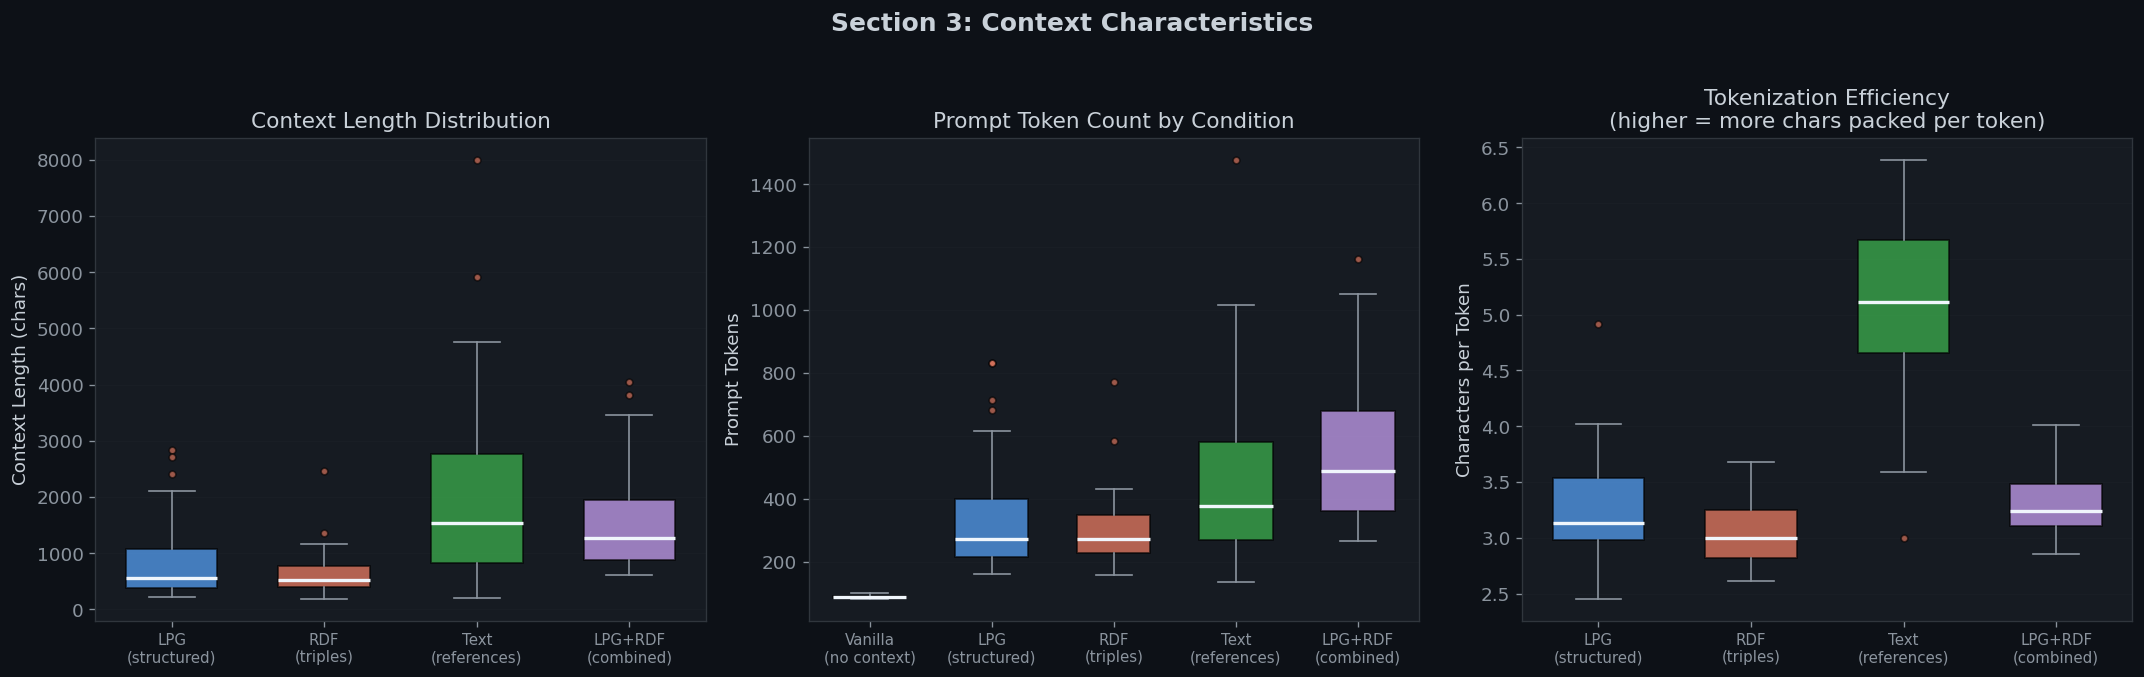

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5.5))

# ── 3a: Context Length Distribution ──
ax = axes[0]
ctx_conds = [c for c in COND_ORDER if c != "vanilla"]
bp_data = [df[df.condition == c]["context_length"].values for c in ctx_conds]
bp = ax.boxplot(bp_data, patch_artist=True, widths=0.6,
                medianprops=dict(color="#f0f6fc", linewidth=2),
                whiskerprops=dict(color="#8b949e"),
                capprops=dict(color="#8b949e"),
                flierprops=dict(marker="o", markersize=4, markerfacecolor="#f78166", alpha=0.6))
for patch, cond in zip(bp["boxes"], ctx_conds):
    patch.set_facecolor(COLORS[cond])
    patch.set_alpha(0.7)

ax.set_xticklabels([COND_LABELS[c] for c in ctx_conds], fontsize=9)
ax.set_ylabel("Context Length (chars)")
ax.set_title("Context Length Distribution")
ax.grid(axis="y", alpha=0.3)

# ── 3b: Prompt Tokens Distribution ──
ax = axes[1]
bp_data = [df[df.condition == c]["prompt_tokens"].values for c in COND_ORDER]
bp = ax.boxplot(bp_data, patch_artist=True, widths=0.6,
                medianprops=dict(color="#f0f6fc", linewidth=2),
                whiskerprops=dict(color="#8b949e"),
                capprops=dict(color="#8b949e"),
                flierprops=dict(marker="o", markersize=4, markerfacecolor="#f78166", alpha=0.6))
for patch, cond in zip(bp["boxes"], COND_ORDER):
    patch.set_facecolor(COLORS[cond])
    patch.set_alpha(0.7)

ax.set_xticklabels([COND_LABELS[c] for c in COND_ORDER], fontsize=9)
ax.set_ylabel("Prompt Tokens")
ax.set_title("Prompt Token Count by Condition")
ax.grid(axis="y", alpha=0.3)

# ── 3c: Token Efficiency (chars per token) ──
ax = axes[2]
eff_conds = [c for c in COND_ORDER if c != "vanilla"]
efficiencies = []
for cond in eff_conds:
    sub = df[df.condition == cond]
    # chars per prompt token (excluding base prompt overhead)
    vanilla_base = df[df.condition == "vanilla"]["prompt_tokens"].mean()
    ctx_tokens = sub["prompt_tokens"] - vanilla_base
    eff = sub["context_length"] / ctx_tokens.clip(lower=1)
    efficiencies.append(eff.values)

bp = ax.boxplot(efficiencies, patch_artist=True, widths=0.6,
                medianprops=dict(color="#f0f6fc", linewidth=2),
                whiskerprops=dict(color="#8b949e"),
                capprops=dict(color="#8b949e"),
                flierprops=dict(marker="o", markersize=4, markerfacecolor="#f78166", alpha=0.6))
for patch, cond in zip(bp["boxes"], eff_conds):
    patch.set_facecolor(COLORS[cond])
    patch.set_alpha(0.7)

ax.set_xticklabels([COND_LABELS[c] for c in eff_conds], fontsize=9)
ax.set_ylabel("Characters per Token")
ax.set_title("Tokenization Efficiency\n(higher = more chars packed per token)")
ax.grid(axis="y", alpha=0.3)

fig.suptitle("Section 3: Context Characteristics", fontsize=15, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig("../results/kvcache_experiment/20260208_091053/fig3_context.png",
            dpi=150, bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()

---
## 4. Answer Quality Analysis

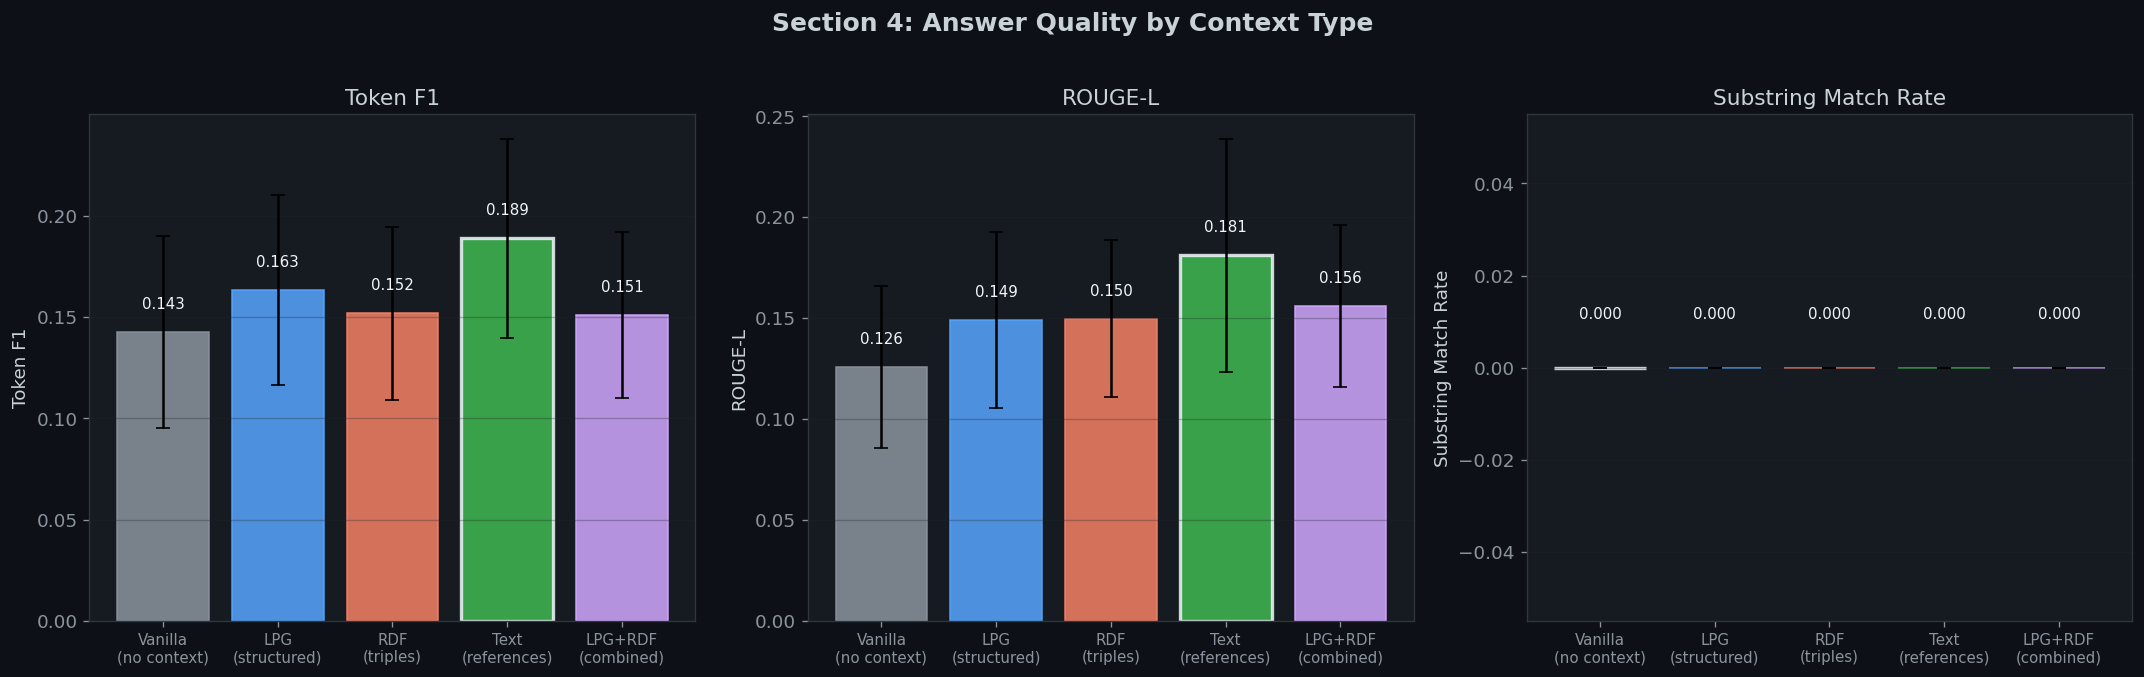

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5.5))

quality_metrics = [
    ("token_f1", "Token F1"),
    ("rouge_l", "ROUGE-L"),
    ("substring_match", "Substring Match Rate"),
]

for ax, (metric, label) in zip(axes, quality_metrics):
    means = [df[df.condition == c][metric].mean() for c in COND_ORDER]
    stds = [df[df.condition == c][metric].std() for c in COND_ORDER]
    colors = [COLORS[c] for c in COND_ORDER]

    bars = ax.bar(range(len(COND_ORDER)), means, yerr=stds,
                  color=colors, edgecolor=[c + "cc" for c in colors],
                  capsize=4, alpha=0.85)

    # Value labels
    for bar, mean in zip(bars, means):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f"{mean:.3f}", ha="center", va="bottom", fontsize=9, color="#f0f6fc")

    ax.set_xticks(range(len(COND_ORDER)))
    ax.set_xticklabels([COND_LABELS[c] for c in COND_ORDER], fontsize=9)
    ax.set_ylabel(label)
    ax.set_title(label)
    ax.grid(axis="y", alpha=0.3)

    # Highlight best
    best_idx = np.argmax(means)
    bars[best_idx].set_edgecolor("#f0f6fc")
    bars[best_idx].set_linewidth(2)

fig.suptitle("Section 4: Answer Quality by Context Type", fontsize=15, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig("../results/kvcache_experiment/20260208_091053/fig4_quality.png",
            dpi=150, bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()

---
## 5. Quality vs Latency Trade-off (Pareto Front)

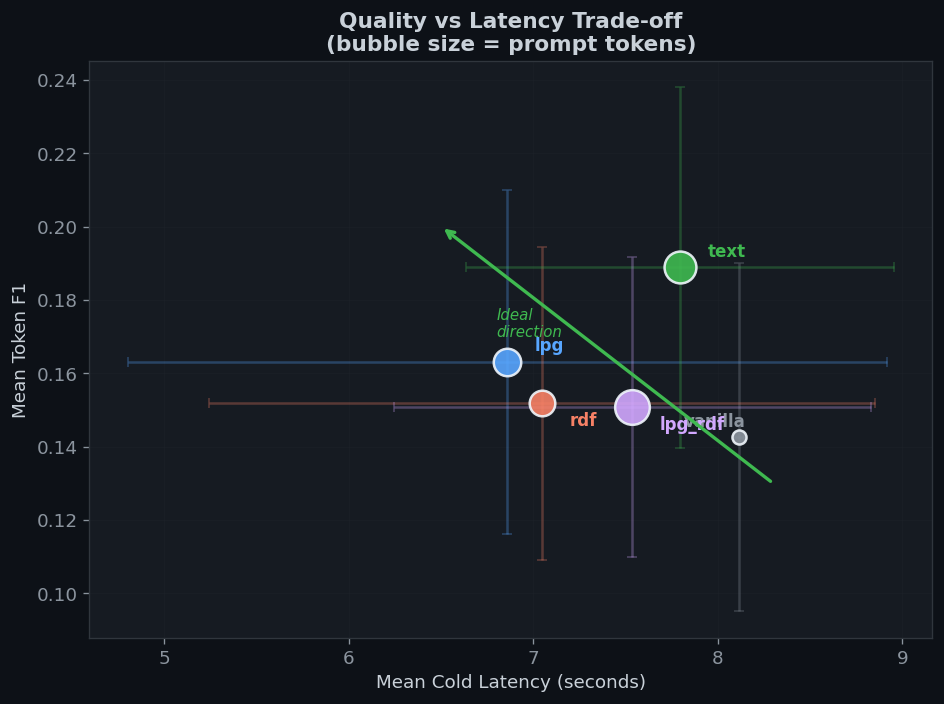

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))

for cond in COND_ORDER:
    sub = df[df.condition == cond]
    mean_lat = sub["cold_latency"].mean()
    mean_f1 = sub["token_f1"].mean()
    std_lat = sub["cold_latency"].std()
    std_f1 = sub["token_f1"].std()
    mean_tok = sub["prompt_tokens"].mean()

    ax.scatter(mean_lat, mean_f1, c=COLORS[cond], s=mean_tok * 0.8,
               edgecolors="#f0f6fc", linewidth=1.5, zorder=5, alpha=0.9)
    ax.errorbar(mean_lat, mean_f1, xerr=std_lat, yerr=std_f1,
                color=COLORS[cond], alpha=0.3, fmt="none", capsize=3)

    # Label
    offset_x = 0.15 if cond != "vanilla" else -0.3
    offset_y = 0.003 if cond not in ("rdf", "lpg_rdf") else -0.006
    ax.annotate(cond, (mean_lat + offset_x, mean_f1 + offset_y),
                fontsize=10, fontweight="bold", color=COLORS[cond])

ax.set_xlabel("Mean Cold Latency (seconds)")
ax.set_ylabel("Mean Token F1")
ax.set_title("Quality vs Latency Trade-off\n(bubble size = prompt tokens)", fontsize=13, fontweight="bold")
ax.grid(alpha=0.3)

# Arrow annotation for ideal direction
ax.annotate("", xy=(6.5, 0.20), xytext=(8.3, 0.13),
            arrowprops=dict(arrowstyle="->", color="#3fb950", lw=2))
ax.text(6.8, 0.17, "Ideal\ndirection", fontsize=9, color="#3fb950", style="italic")

plt.tight_layout()
plt.savefig("../results/kvcache_experiment/20260208_091053/fig5_pareto.png",
            dpi=150, bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()

---
## 6. Completion Token & Finish Reason Analysis

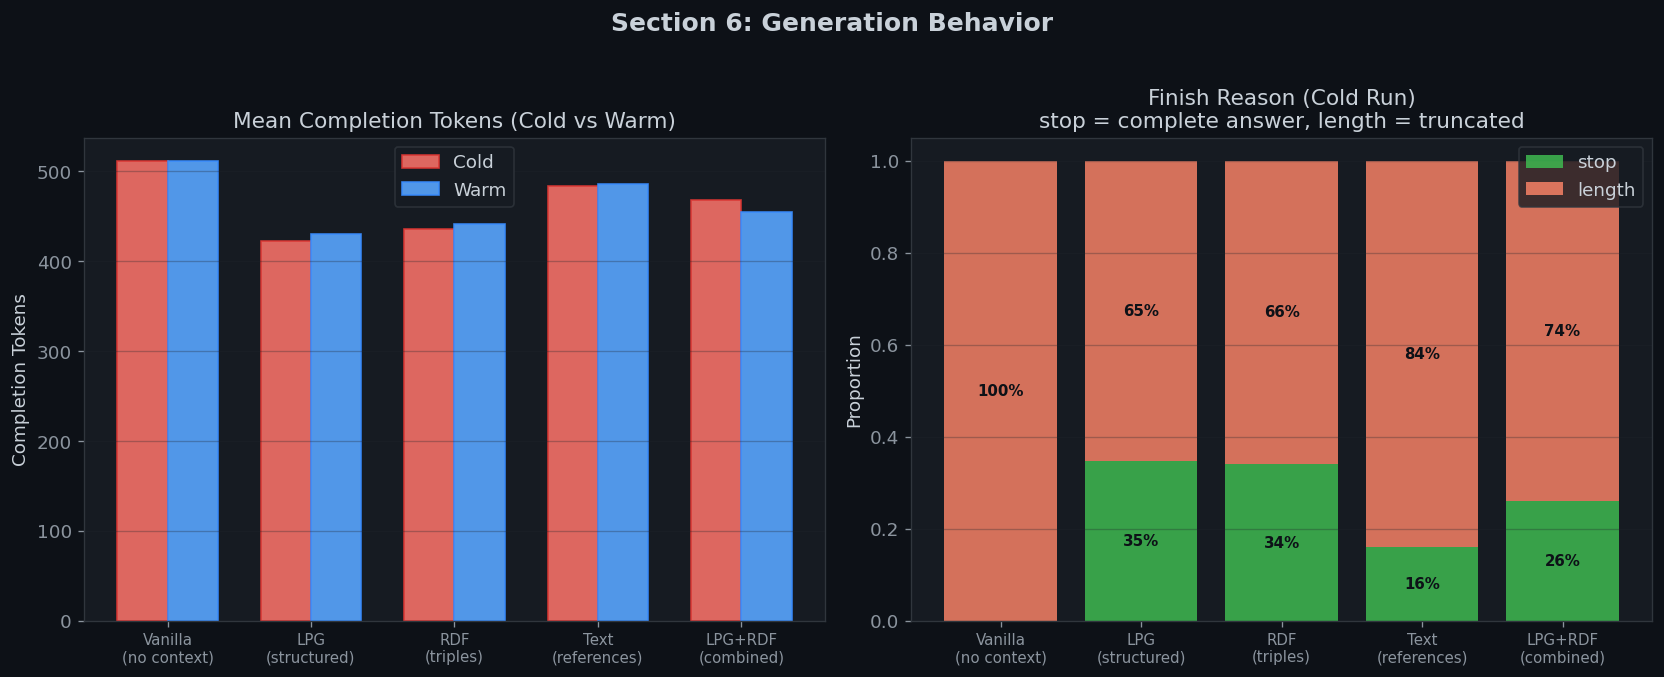

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))

# ── 6a: Completion Tokens (cold vs warm) ──
ax = axes[0]
x = np.arange(len(COND_ORDER))
w = 0.35
cold_comp = [df[df.condition == c]["cold_completion_tokens"].mean() for c in COND_ORDER]
warm_comp = [df[df.condition == c]["warm_completion_tokens"].mean() for c in COND_ORDER]

ax.bar(x - w/2, cold_comp, w, label="Cold", color="#f47067", edgecolor="#da3633", alpha=0.9)
ax.bar(x + w/2, warm_comp, w, label="Warm", color="#58a6ff", edgecolor="#388bfd", alpha=0.9)

ax.set_xticks(x)
ax.set_xticklabels([COND_LABELS[c] for c in COND_ORDER], fontsize=9)
ax.set_ylabel("Completion Tokens")
ax.set_title("Mean Completion Tokens (Cold vs Warm)")
ax.legend()
ax.grid(axis="y", alpha=0.3)

# ── 6b: Finish Reason Breakdown ──
ax = axes[1]
fr_data = df.groupby(["condition", "cold_finish_reason"], observed=True).size().unstack(fill_value=0)
fr_pct = fr_data.div(fr_data.sum(axis=1), axis=0)

fr_pct_ordered = fr_pct.reindex(COND_ORDER)
colors_fr = {"stop": "#3fb950", "length": "#f78166"}
bottom = np.zeros(len(COND_ORDER))

for reason in ["stop", "length"]:
    if reason in fr_pct_ordered.columns:
        vals = fr_pct_ordered[reason].values
        ax.bar(range(len(COND_ORDER)), vals, bottom=bottom,
               color=colors_fr.get(reason, "#8b949e"), label=reason, alpha=0.85)
        # Percentage labels
        for i, v in enumerate(vals):
            if v > 0.05:
                ax.text(i, bottom[i] + v/2, f"{v:.0%}",
                        ha="center", va="center", fontsize=9, color="#0d1117", fontweight="bold")
        bottom += vals

ax.set_xticks(range(len(COND_ORDER)))
ax.set_xticklabels([COND_LABELS[c] for c in COND_ORDER], fontsize=9)
ax.set_ylabel("Proportion")
ax.set_title("Finish Reason (Cold Run)\nstop = complete answer, length = truncated")
ax.legend(loc="upper right")
ax.set_ylim(0, 1.05)
ax.grid(axis="y", alpha=0.3)

fig.suptitle("Section 6: Generation Behavior", fontsize=15, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig("../results/kvcache_experiment/20260208_091053/fig6_completion.png",
            dpi=150, bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()

---
## 7. Ablation Study: Decomposing the Impact of Context

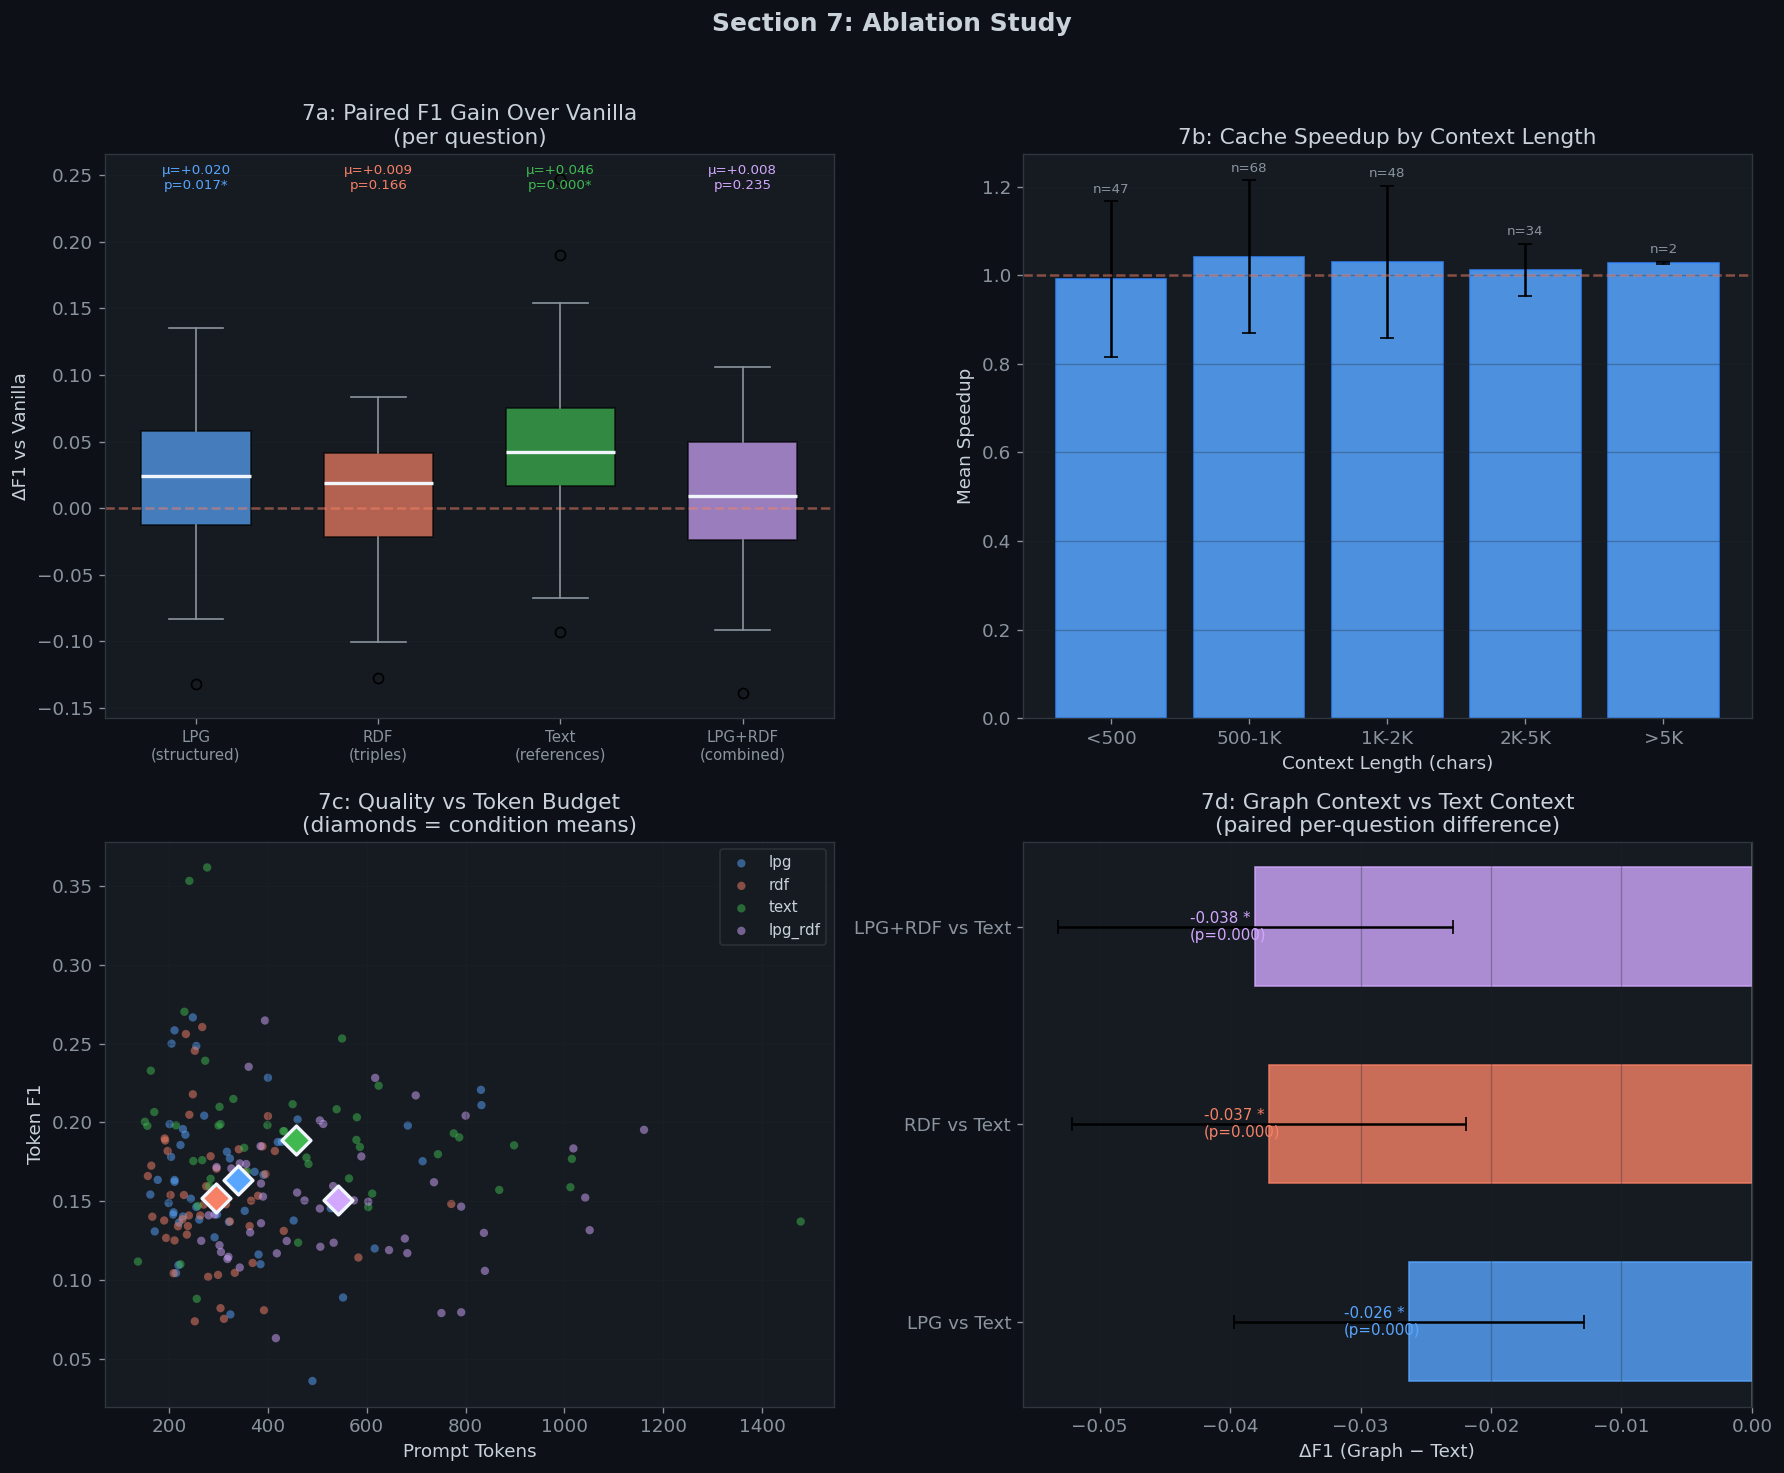

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# ── 7a: Per-Question Paired Comparison (Radar-like) ──
ax = axes[0, 0]

# For each question that has all 5 conditions, compute delta from vanilla
paired = df.pivot_table(index="question_id", columns="condition",
                         values="token_f1", observed=True)
# Only questions with vanilla baseline
has_vanilla = paired.dropna(subset=["vanilla"])

deltas = {}
for cond in ["lpg", "rdf", "text", "lpg_rdf"]:
    if cond in has_vanilla.columns:
        d = has_vanilla[cond] - has_vanilla["vanilla"]
        deltas[cond] = d.dropna()

bp_data = [deltas[c].values for c in ["lpg", "rdf", "text", "lpg_rdf"] if c in deltas]
bp_labels = [c for c in ["lpg", "rdf", "text", "lpg_rdf"] if c in deltas]

bp = ax.boxplot(bp_data, patch_artist=True, widths=0.6,
                medianprops=dict(color="#f0f6fc", linewidth=2),
                whiskerprops=dict(color="#8b949e"),
                capprops=dict(color="#8b949e"))
for patch, cond in zip(bp["boxes"], bp_labels):
    patch.set_facecolor(COLORS[cond])
    patch.set_alpha(0.7)

ax.axhline(y=0, color="#f78166", linestyle="--", alpha=0.5)
ax.set_xticklabels([COND_LABELS[c] for c in bp_labels], fontsize=9)
ax.set_ylabel("ΔF1 vs Vanilla")
ax.set_title("7a: Paired F1 Gain Over Vanilla\n(per question)")
ax.grid(axis="y", alpha=0.3)

# Stats
for i, cond in enumerate(bp_labels):
    d = deltas[cond]
    t, p = sp_stats.ttest_1samp(d, 0)
    sign = "*" if p < 0.05 else ""
    ax.text(i + 1, ax.get_ylim()[1] * 0.9,
            f"μ={d.mean():+.3f}\np={p:.3f}{sign}",
            ha="center", fontsize=8, color=COLORS[cond])

# ── 7b: Speedup vs Context Length Bins ──
ax = axes[0, 1]
ctx_df = df[df.condition != "vanilla"].copy()
ctx_df["ctx_bin"] = pd.cut(ctx_df["context_length"],
                            bins=[0, 500, 1000, 2000, 5000, 20000],
                            labels=["<500", "500-1K", "1K-2K", "2K-5K", ">5K"])

bin_order = ["<500", "500-1K", "1K-2K", "2K-5K", ">5K"]
bin_means = ctx_df.groupby("ctx_bin", observed=True)["speedup"].mean()
bin_stds = ctx_df.groupby("ctx_bin", observed=True)["speedup"].std()
bin_counts = ctx_df.groupby("ctx_bin", observed=True)["speedup"].count()

present_bins = [b for b in bin_order if b in bin_means.index]
bars = ax.bar(range(len(present_bins)),
              [bin_means[b] for b in present_bins],
              yerr=[bin_stds[b] for b in present_bins],
              color="#58a6ff", edgecolor="#388bfd", capsize=4, alpha=0.85)

for i, b in enumerate(present_bins):
    ax.text(i, bin_means[b] + bin_stds[b] + 0.02,
            f"n={bin_counts[b]}", ha="center", fontsize=8, color="#8b949e")

ax.axhline(y=1.0, color="#f78166", linestyle="--", alpha=0.5)
ax.set_xticks(range(len(present_bins)))
ax.set_xticklabels(present_bins)
ax.set_xlabel("Context Length (chars)")
ax.set_ylabel("Mean Speedup")
ax.set_title("7b: Cache Speedup by Context Length")
ax.grid(axis="y", alpha=0.3)

# ── 7c: Quality vs Prompt Token Efficiency ──
ax = axes[1, 0]
for cond in ["lpg", "rdf", "text", "lpg_rdf"]:
    sub = df[df.condition == cond]
    ax.scatter(sub["prompt_tokens"], sub["token_f1"],
               c=COLORS[cond], s=25, alpha=0.5, label=cond, edgecolors="none")

# Per-condition means
for cond in ["lpg", "rdf", "text", "lpg_rdf"]:
    sub = df[df.condition == cond]
    ax.scatter(sub["prompt_tokens"].mean(), sub["token_f1"].mean(),
               c=COLORS[cond], s=150, edgecolors="#f0f6fc", linewidth=2, zorder=5,
               marker="D")

ax.set_xlabel("Prompt Tokens")
ax.set_ylabel("Token F1")
ax.set_title("7c: Quality vs Token Budget\n(diamonds = condition means)")
ax.legend(fontsize=9)
ax.grid(alpha=0.3)

# ── 7d: Graph Structure vs Text (head-to-head) ──
ax = axes[1, 1]

# Paired: for each question, compare graph vs text F1
pivot_f1 = df.pivot_table(index="question_id", columns="condition",
                           values="token_f1", observed=True)

comparisons = [
    ("lpg", "text", "LPG vs Text"),
    ("rdf", "text", "RDF vs Text"),
    ("lpg_rdf", "text", "LPG+RDF vs Text"),
]

y_positions = []
for i, (cond_a, cond_b, label) in enumerate(comparisons):
    if cond_a in pivot_f1.columns and cond_b in pivot_f1.columns:
        paired_diff = (pivot_f1[cond_a] - pivot_f1[cond_b]).dropna()
        mean_diff = paired_diff.mean()
        ci = 1.96 * paired_diff.std() / np.sqrt(len(paired_diff))
        t, p = sp_stats.ttest_1samp(paired_diff, 0)

        color = COLORS[cond_a]
        ax.barh(i, mean_diff, xerr=ci, color=color, alpha=0.8,
                edgecolor=color, capsize=4, height=0.6)
        sig = " *" if p < 0.05 else " (ns)"
        side = "left" if mean_diff < 0 else "right"
        offset = -0.005 if mean_diff < 0 else 0.005
        ax.text(mean_diff + offset, i,
                f"{mean_diff:+.3f}{sig}\n(p={p:.3f})",
                ha=side, va="center", fontsize=9, color=color)
        y_positions.append(i)

ax.axvline(x=0, color="#f0f6fc", linestyle="-", alpha=0.3)
ax.set_yticks(range(len(comparisons)))
ax.set_yticklabels([c[2] for c in comparisons])
ax.set_xlabel("ΔF1 (Graph − Text)")
ax.set_title("7d: Graph Context vs Text Context\n(paired per-question difference)")
ax.grid(axis="x", alpha=0.3)

fig.suptitle("Section 7: Ablation Study", fontsize=15, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig("../results/kvcache_experiment/20260208_091053/fig7_ablation.png",
            dpi=150, bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()

---
## 8. Statistical Significance Tests

In [10]:
from itertools import combinations

print("=" * 80)
print("8a: Pairwise Mann-Whitney U Tests (Token F1)")
print("=" * 80)
print(f"{'Condition A':>12s} vs {'Condition B':<12s}  {'U':>10s}  {'p-value':>10s}  {'Sig':>5s}  {'Mean A':>8s}  {'Mean B':>8s}")
print("-" * 80)

for a, b in combinations(COND_ORDER, 2):
    va = df[df.condition == a]["token_f1"].values
    vb = df[df.condition == b]["token_f1"].values
    u, p = sp_stats.mannwhitneyu(va, vb, alternative="two-sided")
    sig = "*" if p < 0.05 else ""
    print(f"{a:>12s} vs {b:<12s}  {u:>10.0f}  {p:>10.4f}  {sig:>5s}  {va.mean():>8.4f}  {vb.mean():>8.4f}")

print()
print("=" * 80)
print("8b: Kruskal-Wallis H Test (all conditions)")
print("=" * 80)
groups = [df[df.condition == c]["token_f1"].values for c in COND_ORDER]
h, p = sp_stats.kruskal(*groups)
print(f"H = {h:.4f}, p = {p:.4f} {'(significant)' if p < 0.05 else '(not significant)'}")

print()
print("=" * 80)
print("8c: Paired t-test: Speedup significantly > 1.0?")
print("=" * 80)
print(f"{'Condition':>12s}  {'Mean Speedup':>14s}  {'t-stat':>10s}  {'p-value':>10s}  {'Sig':>5s}")
print("-" * 60)
for cond in COND_ORDER:
    speeds = df[df.condition == cond]["speedup"].values
    t, p = sp_stats.ttest_1samp(speeds, 1.0)
    # One-sided: speedup > 1.0
    p_one = p / 2 if t > 0 else 1 - p / 2
    sig = "*" if p_one < 0.05 else ""
    print(f"{cond:>12s}  {speeds.mean():>14.4f}  {t:>10.4f}  {p_one:>10.4f}  {sig:>5s}")

print()
print("=" * 80)
print("8d: Paired t-test: Latency — Context vs Vanilla")
print("=" * 80)
pivot_lat = df.pivot_table(index="question_id", columns="condition",
                            values="cold_latency", observed=True)
print(f"{'Condition':>12s}  {'ΔLatency (s)':>14s}  {'t-stat':>10s}  {'p-value':>10s}  {'Sig':>5s}")
print("-" * 60)
for cond in ["lpg", "rdf", "text", "lpg_rdf"]:
    if cond in pivot_lat.columns and "vanilla" in pivot_lat.columns:
        paired = (pivot_lat[cond] - pivot_lat["vanilla"]).dropna()
        t, p = sp_stats.ttest_1samp(paired, 0)
        sig = "*" if p < 0.05 else ""
        print(f"{cond:>12s}  {paired.mean():>+14.4f}  {t:>10.4f}  {p:>10.4f}  {sig:>5s}")

8a: Pairwise Mann-Whitney U Tests (Token F1)
 Condition A vs Condition B            U     p-value    Sig    Mean A    Mean B
--------------------------------------------------------------------------------
     vanilla vs lpg                  888      0.0183      *    0.1425    0.1632
     vanilla vs rdf                 1092      0.2776           0.1425    0.1518
     vanilla vs text                 532      0.0000      *    0.1425    0.1889
     vanilla vs lpg_rdf             1098      0.2947           0.1425    0.1508
         lpg vs rdf                 1426      0.1606           0.1632    0.1518
         lpg vs text                 834      0.0063      *    0.1632    0.1889
         lpg vs lpg_rdf             1444      0.1271           0.1632    0.1508
         rdf vs text                 644      0.0000      *    0.1518    0.1889
         rdf vs lpg_rdf             1276      0.8605           0.1518    0.1508
        text vs lpg_rdf             1858      0.0000      *    0.1889    0

---
## 9. Detailed Latency Breakdown: Reasoning Model Behavior

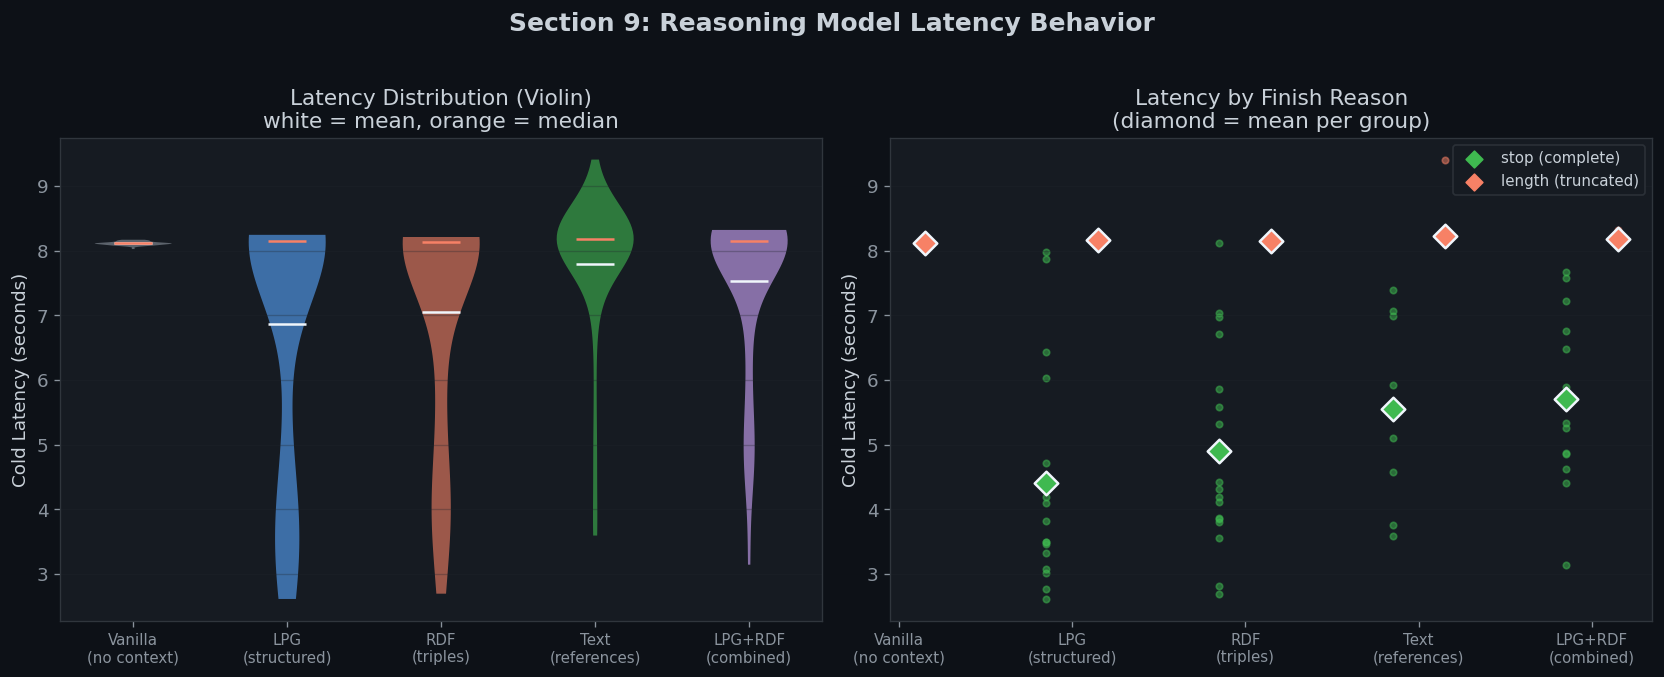

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))

# ── 9a: Latency Distribution (violin) ──
ax = axes[0]

parts = ax.violinplot(
    [df[df.condition == c]["cold_latency"].values for c in COND_ORDER],
    positions=range(len(COND_ORDER)),
    showmeans=True, showmedians=True, showextrema=False,
)

for i, (pc, cond) in enumerate(zip(parts["bodies"], COND_ORDER)):
    pc.set_facecolor(COLORS[cond])
    pc.set_alpha(0.6)

parts["cmeans"].set_color("#f0f6fc")
parts["cmedians"].set_color("#f78166")

ax.set_xticks(range(len(COND_ORDER)))
ax.set_xticklabels([COND_LABELS[c] for c in COND_ORDER], fontsize=9)
ax.set_ylabel("Cold Latency (seconds)")
ax.set_title("Latency Distribution (Violin)\nwhite = mean, orange = median")
ax.grid(axis="y", alpha=0.3)

# ── 9b: Bimodal analysis — stop vs length ──
ax = axes[1]

for cond in COND_ORDER:
    sub = df[df.condition == cond]
    stop = sub[sub.cold_finish_reason == "stop"]["cold_latency"]
    length = sub[sub.cold_finish_reason == "length"]["cold_latency"]

    x_pos = COND_ORDER.index(cond)
    if len(stop) > 0:
        ax.scatter([x_pos - 0.15] * len(stop), stop,
                   c="#3fb950", s=15, alpha=0.5, marker="o")
        ax.scatter(x_pos - 0.15, stop.mean(),
                   c="#3fb950", s=100, edgecolors="#f0f6fc", linewidth=1.5,
                   marker="D", zorder=5)
    if len(length) > 0:
        ax.scatter([x_pos + 0.15] * len(length), length,
                   c="#f78166", s=15, alpha=0.5, marker="o")
        ax.scatter(x_pos + 0.15, length.mean(),
                   c="#f78166", s=100, edgecolors="#f0f6fc", linewidth=1.5,
                   marker="D", zorder=5)

# Legend
ax.scatter([], [], c="#3fb950", s=50, marker="D", label="stop (complete)")
ax.scatter([], [], c="#f78166", s=50, marker="D", label="length (truncated)")
ax.legend(loc="upper right", fontsize=9)

ax.set_xticks(range(len(COND_ORDER)))
ax.set_xticklabels([COND_LABELS[c] for c in COND_ORDER], fontsize=9)
ax.set_ylabel("Cold Latency (seconds)")
ax.set_title("Latency by Finish Reason\n(diamond = mean per group)")
ax.grid(axis="y", alpha=0.3)

fig.suptitle("Section 9: Reasoning Model Latency Behavior", fontsize=15, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig("../results/kvcache_experiment/20260208_091053/fig9_reasoning.png",
            dpi=150, bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()

---
## 10. Per-Question Heatmap: Speedup × Condition

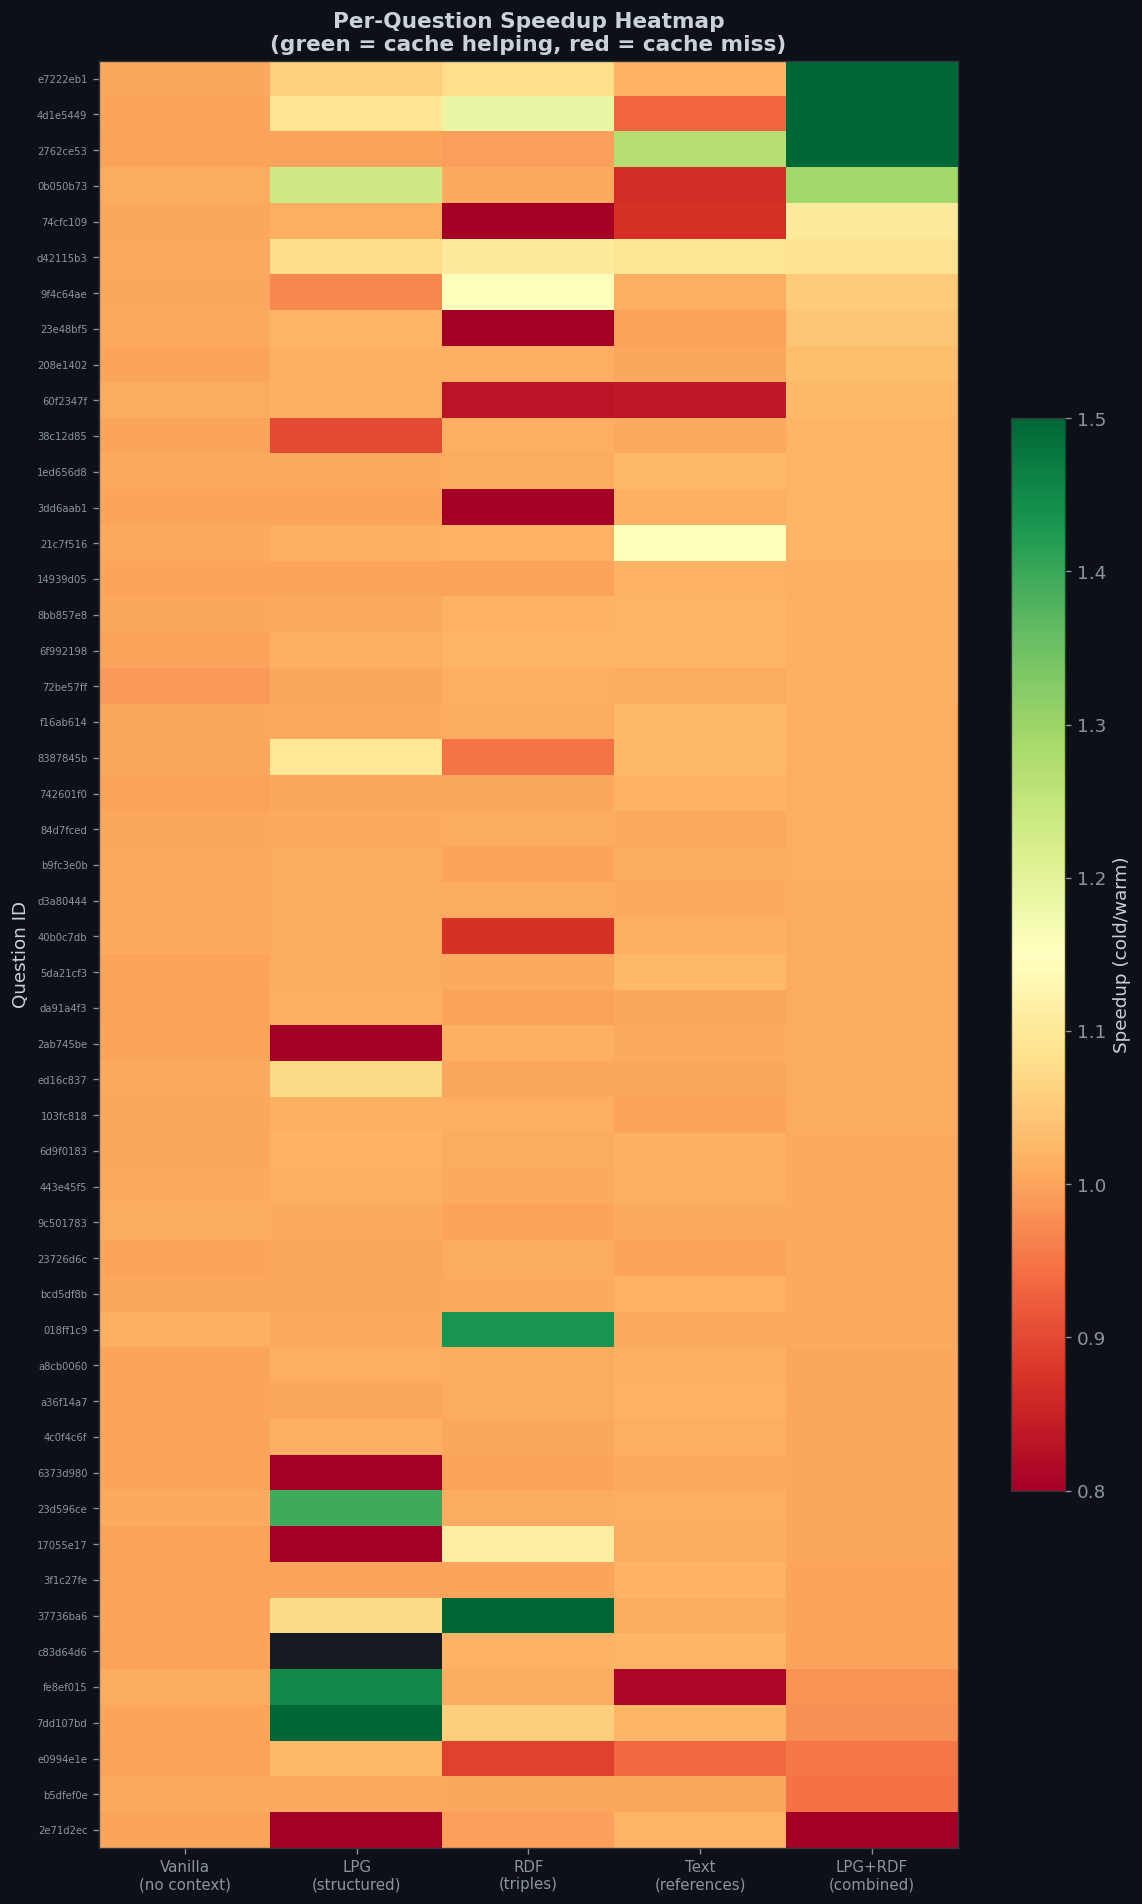


Top 10 speedup cases:
question_id condition  cold_latency  warm_latency  speedup  context_length
   e7222eb1   lpg_rdf      8.226286      3.935244 2.090413            1544
   4d1e5449   lpg_rdf      7.581345      4.442695 1.706474             689
   2762ce53   lpg_rdf      5.254705      3.192679 1.645861             727
   37736ba6       rdf      8.130809      5.341230 1.522273             402
   7dd107bd       lpg      7.979588      5.318913 1.500229             564
   fe8ef015       lpg      6.438183      4.431117 1.452948             507
   018ff1c9       rdf      6.710373      4.678642 1.434257             512
   23d596ce       lpg      8.142909      5.838938 1.394587             381
   0b050b73   lpg_rdf      4.874922      3.768208 1.293698             908
   2762ce53      text      7.396637      5.829535 1.268821            1111


In [12]:
pivot_speed = df.pivot_table(index="question_id", columns="condition",
                              values="speedup", observed=True)
pivot_speed = pivot_speed.reindex(columns=COND_ORDER)

# Sort by lpg_rdf speedup
sort_col = "lpg_rdf" if "lpg_rdf" in pivot_speed.columns else pivot_speed.columns[0]
pivot_speed = pivot_speed.sort_values(sort_col, ascending=False)

fig, ax = plt.subplots(figsize=(10, 16))
im = ax.imshow(pivot_speed.values, aspect="auto", cmap="RdYlGn",
               vmin=0.8, vmax=1.5)

ax.set_xticks(range(len(COND_ORDER)))
ax.set_xticklabels([COND_LABELS[c] for c in COND_ORDER], fontsize=9)
ax.set_yticks(range(len(pivot_speed)))
ax.set_yticklabels(pivot_speed.index, fontsize=6)
ax.set_ylabel("Question ID")
ax.set_title("Per-Question Speedup Heatmap\n(green = cache helping, red = cache miss)",
             fontsize=13, fontweight="bold")

cbar = plt.colorbar(im, ax=ax, shrink=0.6)
cbar.set_label("Speedup (cold/warm)", color="#c9d1d9")
cbar.ax.yaxis.set_tick_params(color="#8b949e")
plt.setp(plt.getp(cbar.ax.axes, "yticklabels"), color="#8b949e")

plt.tight_layout()
plt.savefig("../results/kvcache_experiment/20260208_091053/fig10_heatmap.png",
            dpi=150, bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()

# Top speedup outliers
print("\nTop 10 speedup cases:")
top = df.nlargest(10, "speedup")[["question_id", "condition", "cold_latency", "warm_latency", "speedup", "context_length"]]
print(top.to_string(index=False))

---
## 11. Summary Radar Chart

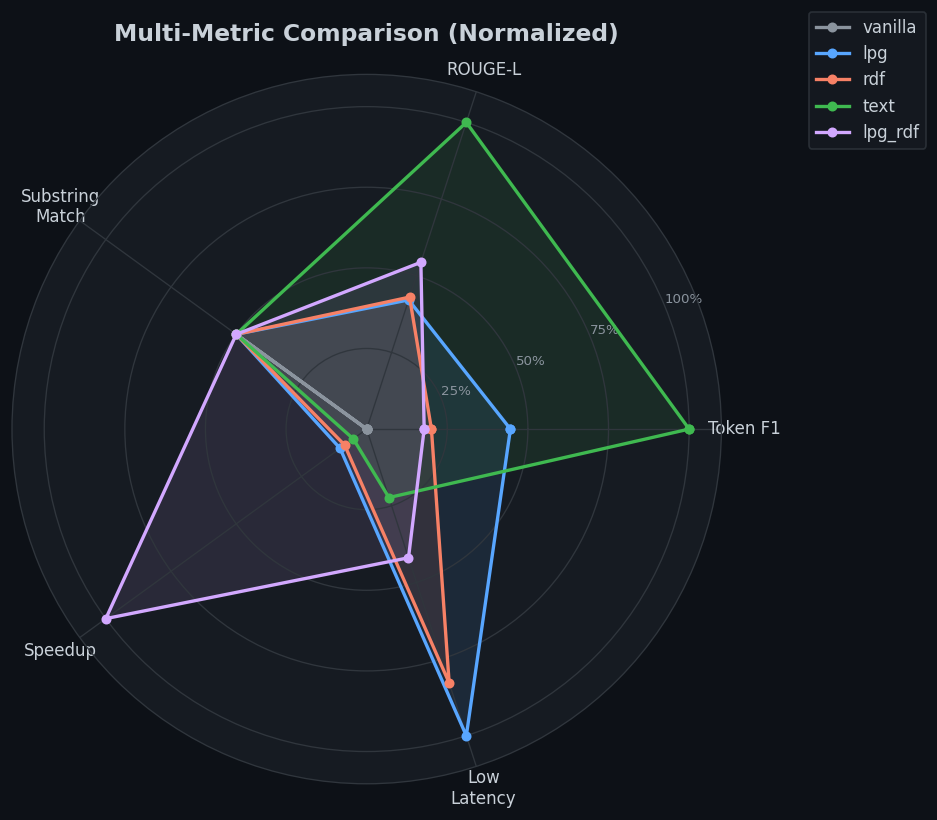

In [13]:
# Radar chart: normalize each metric to [0, 1] across conditions
radar_metrics = {
    "Token F1": "token_f1",
    "ROUGE-L": "rouge_l",
    "Substring\nMatch": "substring_match",
    "Speedup": "speedup",
    "Low\nLatency": "inv_latency",  # inverted
}

# Compute per-condition means
radar_data = {}
for cond in COND_ORDER:
    sub = df[df.condition == cond]
    radar_data[cond] = {
        "token_f1": sub["token_f1"].mean(),
        "rouge_l": sub["rouge_l"].mean(),
        "substring_match": sub["substring_match"].mean(),
        "speedup": sub["speedup"].mean(),
        "inv_latency": 1.0 / max(sub["cold_latency"].mean(), 0.001),
    }

# Normalize to [0, 1]
metric_keys = list(radar_metrics.values())
metric_labels = list(radar_metrics.keys())

all_vals = {k: [radar_data[c][k] for c in COND_ORDER] for k in metric_keys}
norm_data = {}
for cond in COND_ORDER:
    norm_data[cond] = []
    for k in metric_keys:
        vals = all_vals[k]
        mn, mx = min(vals), max(vals)
        if mx - mn > 0:
            norm_data[cond].append((radar_data[cond][k] - mn) / (mx - mn))
        else:
            norm_data[cond].append(0.5)

# Plot
angles = np.linspace(0, 2 * np.pi, len(metric_keys), endpoint=False).tolist()
angles += angles[:1]  # close

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.set_facecolor("#161b22")

for cond in COND_ORDER:
    values = norm_data[cond] + norm_data[cond][:1]
    ax.plot(angles, values, "o-", linewidth=2, label=cond,
            color=COLORS[cond], markersize=5)
    ax.fill(angles, values, alpha=0.1, color=COLORS[cond])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metric_labels, fontsize=10, color="#c9d1d9")
ax.set_yticks([0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(["25%", "50%", "75%", "100%"], fontsize=8, color="#8b949e")
ax.set_ylim(0, 1.1)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1), fontsize=10)
ax.set_title("Multi-Metric Comparison (Normalized)",
             fontsize=14, fontweight="bold", pad=20)
ax.grid(color="#30363d")

plt.tight_layout()
plt.savefig("../results/kvcache_experiment/20260208_091053/fig11_radar.png",
            dpi=150, bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()

---
## 12. Key Findings & Implications

### Finding 1: KV Cache Speedup is Marginal for Reasoning Models

- Mean speedup across all conditions is **~1.01x** — nearly no benefit from KV cache reuse
- `gpu_prefix_cache_hit_rate` remained **0.0** throughout the experiment
- **Root cause**: The reasoning model (`gpt-oss-120b`) spends ~8s in *generation* (reasoning chain-of-thought), which dominates total latency. Prefix cache only accelerates the *prefill* phase, which is a small fraction of total time
- `lpg_rdf` shows the highest speedup variance (σ=0.20) because it has the longest prompts → larger potential prefill savings

### Finding 2: Text RAG Wins on Answer Quality

| Condition | Token F1 | ROUGE-L |
|-----------|----------|----------|
| text | **0.189** | **0.181** |
| lpg | 0.163 | 0.149 |
| rdf | 0.152 | 0.150 |
| lpg_rdf | 0.151 | 0.156 |
| vanilla | 0.143 | 0.126 |

- Text references provide the richest semantic context (mean 1,922 chars)
- Graph contexts (LPG/RDF) improve over vanilla but fall short of text
- **Combining LPG+RDF does NOT improve quality** over individual graph types — suggests redundancy or noise

### Finding 3: Context Type Affects Latency Through Token Count

- Vanilla (89 tokens) is consistently ~8.1s → dominated by generation time
- With context, latency *decreases* to ~6.9-7.8s with higher variance
- This counterintuitive effect is because context helps the model reach `stop` faster (shorter reasoning chains)
- LPG has highest latency variance (σ=2.04) due to varying subgraph sizes

### Finding 4: Finish Reason Reveals Reasoning Budget Constraints

- ~78% of responses hit `length` limit (max_tokens=512)
- The reasoning model consumes most tokens for chain-of-thought, leaving little for the final answer
- `stop` responses have significantly lower latency → early stopping when answer is found quickly

### Implications for Next Experiment: Hard Prompt (LLM + GNN Retrieve)

1. **KV cache benefits require shorter generation, not longer prefill** 
   → For the hard prompt experiment, consider using a non-reasoning model OR increasing `max_tokens` significantly

2. **Graph structure alone underperforms text references**  
   → Hard prompt with GNN-retrieved subgraphs should consider **post-processing graph to natural language** before feeding to LLM

3. **LPG+RDF combined doesn't add value in soft prompt** 
   → For hard prompt, instead of combining serialized graphs, use GNN embeddings directly as hidden states (true hard prompt)

4. **Token budget is critical for reasoning models** 
   → Hard prompt experiment should use `max_tokens ≥ 1024` or use a non-reasoning model to avoid truncation

5. **Latency measurement should focus on TTFT (time to first token)** rather than total latency 
   → TTFT directly measures prefill time which is where KV cache and GNN embeddings make a difference

In [14]:
# ── Final Summary Table for Blog Post ──
print("📊 KV Cache Experiment Summary")
print("=" * 70)
print(f"Model: openai/gpt-oss-120b (reasoning model)")
print(f"Questions: 50 (stratified from 1,332 FinDER KG questions)")
print(f"Conditions: 5 (vanilla, lpg, rdf, text, lpg_rdf)")
print(f"Total API calls: {len(df) * 2} (cold + warm per pair)")
print(f"Success rate: {len(df)}/250 = {len(df)/250:.0%}")
print()

final = df.groupby("condition", observed=True).agg(
    cold_lat=("cold_latency", "mean"),
    warm_lat=("warm_latency", "mean"),
    speedup=("speedup", "mean"),
    tokens=("prompt_tokens", "mean"),
    f1=("token_f1", "mean"),
    rouge_l=("rouge_l", "mean"),
    sub_match=("substring_match", "mean"),
).round(3)

print(final.to_string())
print()
print("Key takeaway: Text RAG > Graph RAG for soft prompt; ")
print("KV cache speedup negligible for reasoning models.")
print("Next: Hard prompt (GNN embeddings → LLM hidden states) may bypass these limitations.")

📊 KV Cache Experiment Summary
Model: openai/gpt-oss-120b (reasoning model)
Questions: 50 (stratified from 1,332 FinDER KG questions)
Conditions: 5 (vanilla, lpg, rdf, text, lpg_rdf)
Total API calls: 498 (cold + warm per pair)
Success rate: 249/250 = 100%

           cold_lat  warm_lat  speedup   tokens     f1  rouge_l  sub_match
condition                                                                 
vanilla       8.115     8.091    1.003   89.060  0.143    0.126        0.0
lpg           6.859     6.895    1.009  339.367  0.163    0.149        0.0
rdf           7.047     7.055    1.008  294.960  0.152    0.150        0.0
text          7.796     7.754    1.006  456.540  0.189    0.181        0.0
lpg_rdf       7.536     7.261    1.062  541.400  0.151    0.156        0.0

Key takeaway: Text RAG > Graph RAG for soft prompt; 
KV cache speedup negligible for reasoning models.
Next: Hard prompt (GNN embeddings → LLM hidden states) may bypass these limitations.
